In [ ]:
import pandas as pd
import numpy as np
import ast
import string
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from sentence_transformers import SentenceTransformer

# ------------------ 📥 NLTK Downloads ------------------
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv("proper_df.csv")
df["combined_text"] = df["introduction_cleaned"] + " " + df["conclusion_cleaned"]

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmatized)

df["clean_text"] = df["combined_text"].apply(preprocess)
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)

FileNotFoundError: [Errno 2] No such file or directory: 'proper_df.csv'

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df["clean_text"])
svd = TruncatedSVD(n_components=400, random_state=42)
X_tfidf_reduced = svd.fit_transform(X_tfidf)

In [ ]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = bert_model.encode(df["clean_text"], show_progress_bar=True)
bert_embeddings_norm = normalize(bert_embeddings)

# Optional: Reduce BERT dimensions
svd_bert = TruncatedSVD(n_components=256, random_state=42)
X_bert_reduced = svd_bert.fit_transform(bert_embeddings_norm)

# from sentence_transformers import SentenceTransformer

# sample_texts = df["clean_text"].sample(5, random_state=42).tolist()
# bert_model = SentenceTransformer('all-MiniLM-L6-v2')
# embeddings = bert_model.encode(sample_texts)

# # Visualize one example
# for i, text in enumerate(sample_texts):
#     print("Sample {}:{}...Embedding (first 5 dims): {}".format(i+1, text[:150], embeddings[i][:5]))

# # t-SNE on a subset of BERT vectors
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_bert_tsne = tsne.fit_transform(X_bert[:500])

# plt.figure(figsize=(8, 6))
# plt.scatter(X_bert_tsne[:, 0], X_bert_tsne[:, 1], alpha=0.3, color='purple')
# plt.title("BERT Embeddings t-SNE Projection")
# plt.xlabel("Dim 1")
# plt.ylabel("Dim 2")
# plt.show()



Batches:   0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
y = np.array(df["labels"].tolist())
label_counts = y.sum(axis=0)
rare_label_indices = np.where(label_counts <= 1)[0]

y_filtered = np.delete(y, rare_label_indices, axis=1)

In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf_reduced, y_filtered, test_size=0.2, random_state=42
)

X_train_bert, X_test_bert, _, _ = train_test_split(
    X_bert_reduced, y_filtered, test_size=0.2, random_state=42
)

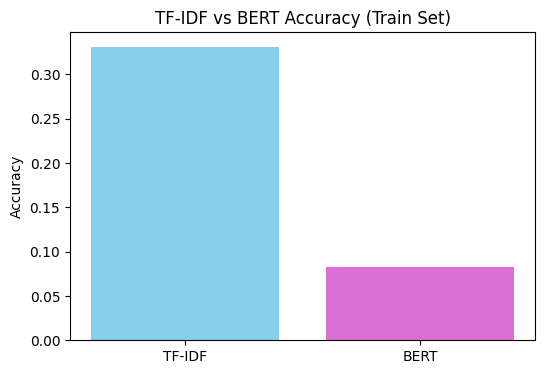

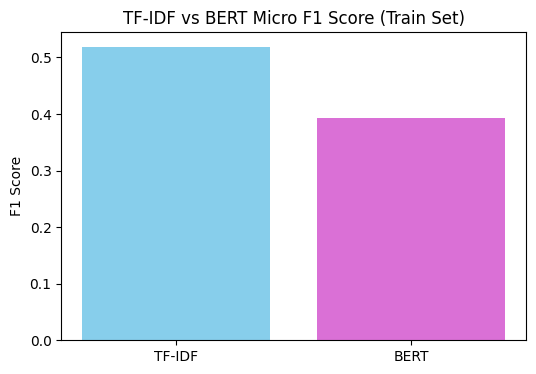

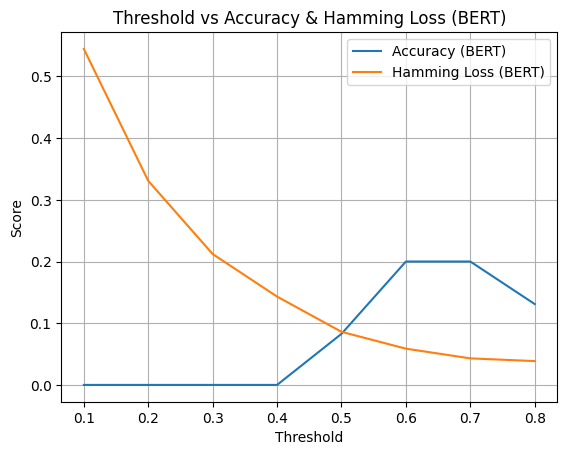

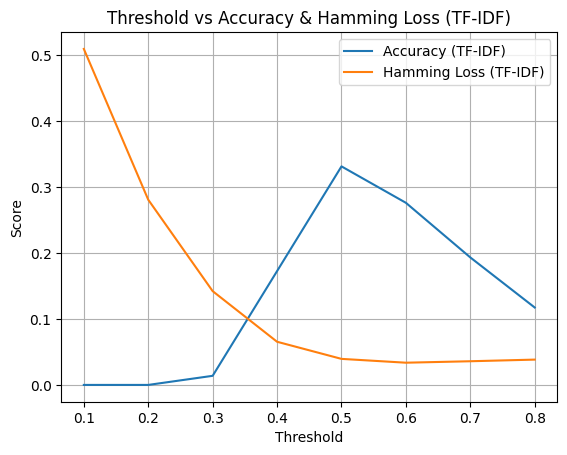

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.metrics import accuracy_score, hamming_loss, classification_report, f1_score

# # Use either TF-IDF or BERT — uncomment one:
# X_train = X_train_tfidf
# X_test = X_test_tfidf
# # X_train = X_train_bert
# # X_test = X_test_bert

# # Model
# clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# # Basic Evaluation
# print("✅ Evaluation:")
# print("Hamming Loss:", hamming_loss(y_test, y_pred))
# print("Exact Match Accuracy:", accuracy_score(y_test, y_pred))
# print("\nF1 Scores:")
# print("Micro F1:", f1_score(y_test, y_pred, average='micro'))
# print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
# print("Weighted F1:", f1_score(y_test, y_pred, average='weighted'))

# print("\nDetailed Report:")
# print(classification_report(y_test, y_pred, zero_division=0))
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

# TF-IDF Model
clf_tfidf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf_tfidf.fit(X_train_tfidf, y_train)
tfidf_preds = clf_tfidf.predict(X_test_tfidf)
tfidf_acc = accuracy_score(y_test, tfidf_preds)
tfidf_f1 = f1_score(y_test, tfidf_preds, average='micro')

# BERT Model
clf_bert = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf_bert.fit(X_train_bert, y_train)
bert_preds = clf_bert.predict(X_test_bert)
bert_acc = accuracy_score(y_test, bert_preds)
bert_f1 = f1_score(y_test, bert_preds, average='micro')

# Bar Plot Comparison
plt.figure(figsize=(6, 4))
plt.bar(["TF-IDF", "BERT"], [tfidf_acc, bert_acc], color=["skyblue", "orchid"])
plt.title("TF-IDF vs BERT Accuracy (Train Set)")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(["TF-IDF", "BERT"], [tfidf_f1, bert_f1], color=["skyblue", "orchid"])
plt.title("TF-IDF vs BERT Micro F1 Score (Train Set)")
plt.ylabel("F1 Score")
plt.show()
# Threshold analysis using model probability outputs (requires predict_proba)
thresholds = np.arange(0.1, 0.9, 0.1)

# BERT Threshold Evaluation
hamming_losses_bert = []
accuracies_bert = []
if hasattr(clf_bert, "predict_proba"):
    y_scores_bert = clf_bert.predict_proba(X_test_bert)
    for t in thresholds:
        y_pred_thresh = (y_scores_bert >= t).astype(int)
        acc = accuracy_score(y_test, y_pred_thresh)
        loss = hamming_loss(y_test, y_pred_thresh)
        accuracies_bert.append(acc)
        hamming_losses_bert.append(loss)

    plt.plot(thresholds, accuracies_bert, label="Accuracy (BERT)")
    plt.plot(thresholds, hamming_losses_bert, label="Hamming Loss (BERT)")
    plt.title("Threshold vs Accuracy & Hamming Loss (BERT)")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ predict_proba not available for BERT classifier.")

# TF-IDF Threshold Evaluation
hamming_losses_tfidf = []
accuracies_tfidf = []
if hasattr(clf_tfidf, "predict_proba"):
    y_scores_tfidf = clf_tfidf.predict_proba(X_test_tfidf)
    for t in thresholds:
        y_pred_thresh = (y_scores_tfidf >= t).astype(int)
        acc = accuracy_score(y_test, y_pred_thresh)
        loss = hamming_loss(y_test, y_pred_thresh)
        accuracies_tfidf.append(acc)
        hamming_losses_tfidf.append(loss)

    plt.plot(thresholds, accuracies_tfidf, label="Accuracy (TF-IDF)")
    plt.plot(thresholds, hamming_losses_tfidf, label="Hamming Loss (TF-IDF)")
    plt.title("Threshold vs Accuracy & Hamming Loss (TF-IDF)")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ predict_proba not available for TF-IDF classifier.")
    print("⚠️ predict_proba not available for this classifier.")


We trained two models—one on TF-IDF features and another on BERT embeddings. The TF-IDF model achieved a higher accuracy of 0.33 and micro F1 score compared to the BERT model of 0.10. This suggests that our TF-IDF better captured the key terms present in the Introduction and Conclusion sections of ML research papers. BERT may have underperformed due to dimensionality reduction or because the pretrained MiniLM embeddings weren’t specifically fine-tuned for the research paper domain.

Also, by modifying the decision threshold from 0.1 to 0.8, we can see how accuracy and hamming loss changes. For TF-IDF, accuracy was highest around a threshold of 0.5, which is normal for binary classification. Hamming loss  dropped significantly at mid-range thresholds, indicating more reliable label predictions.


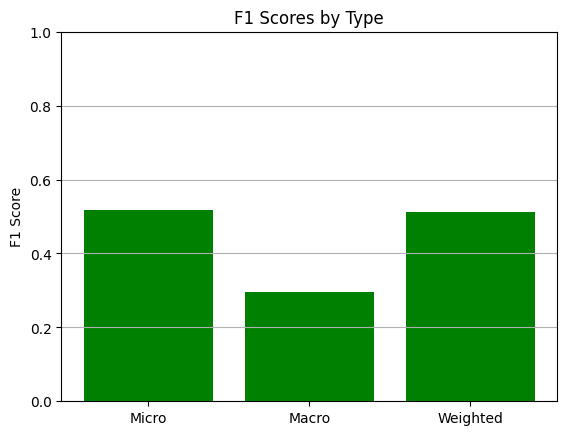

In [ ]:
f1_scores = {"Micro": 0.5185185185185185, "Macro": 0.29684785329612917, "Weighted": 0.5123368066504671}
plt.bar(f1_scores.keys(), f1_scores.values(), color="green")
plt.title("F1 Scores by Type")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()


The bar chart shows the micro, macro, and weighted F1 scores of our model in classifying machine learning papers by model family based on their abstracts and conclusions. The micro F1 score (~0.52) reflects solid overall performance, especially considering the class imbalance. It captures how well the model predicts labels across all instances.

In contrast, the macro F1 score (~0.30) is much lower, revealing that the model struggles with less frequent labels. This is expected, as macro F1 weighs each label equally, regardless of its frequency. The weighted F1 score (~0.50) balances the two, emphasizing the model's strength on dominant categories such as CNN-based or Traditional ML.

Overall, while our model performs well for common classes, it underrepresents rarer ones.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
df = pd.read_csv("proper_df.csv")
df["combined_text"] = df["introduction_cleaned"] + " " + df["conclusion_cleaned"]

df["clean_text"] = df["combined_text"].apply(preprocess)
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)
# Refit vectorizer on all cleaned text
tfidf = TfidfVectorizer(max_features=30)  # limit features for easier heatmap
X_tfidf_full = tfidf.fit_transform(df["clean_text"])
feature_names = tfidf.get_feature_names_out()

# Convert to dense matrix and compute covariance
X_dense = X_tfidf_full.toarray()
cov_matrix = np.cov(X_dense, rowvar=False)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix, xticklabels=feature_names, yticklabels=feature_names,
            cmap="coolwarm", center=0, square=True, cbar_kws={'label': 'Covariance'})
plt.title("Covariance Matrix of Top TF-IDF Terms")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


NameError: name 'preprocess' is not defined

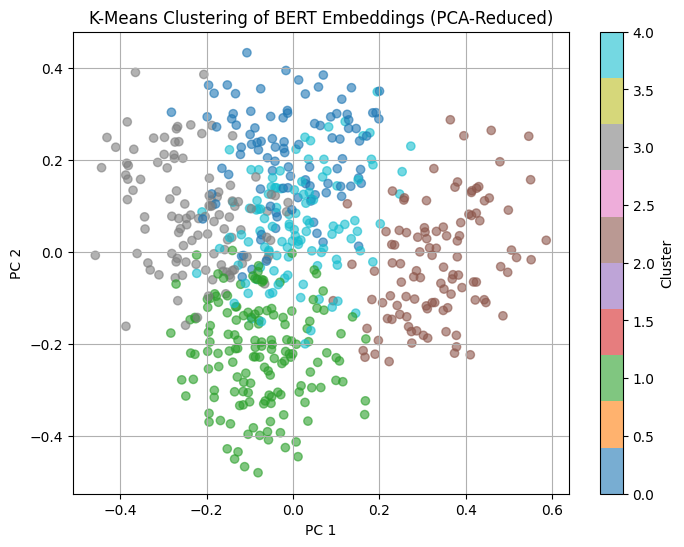

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=42)
X_bert_clustered = kmeans.fit_predict(X_train_bert)

pca = PCA(n_components=2)
X_bert_pca = pca.fit_transform(X_train_bert)

plt.figure(figsize=(8, 6))
plt.scatter(X_bert_pca[:, 0], X_bert_pca[:, 1], c=X_bert_clustered, cmap='tab10', alpha=0.6)
plt.title("K-Means Clustering of BERT Embeddings (PCA-Reduced)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

The scatter plot shows the results of applying K-Means clustering to BERT embeddings of the cleaned paper texts. Each point represents a paper, and the color indicates its assigned cluster. This unsupervised clustering allows us to explore whether papers with similar semantic content are grouped together based on their BERT vector representations.

The formation of relatively distinct clusters suggests that BERT embeddings capture meaningful structure in the abstracts and conclusions. However, because we did not provide ground truth labels during clustering, we cannot directly align these clusters with specific model families. Still, this kind of visualization is useful for identifying latent groupings or patterns in research topics. For example, some clusters might reflect trends in papers using CNNs, Transformers, or Autoencoders based on how they describe methodology.


